# 2019 POLEVAL TASK 6.2
**Fit ML models**


---





http://2019.poleval.pl/index.php/tasks/task6


## To install and download

In [1]:
from IPython.display import clear_output
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import re
import numpy as np
import string
import time

# sklearn - modele do ML
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import seaborn as sns
# model
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# ewaluacja
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [2]:
#Authenticate
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
path1 = '/content/drive/MyDrive/POLEVAL_6.2/train_data_preprocessed.csv' 
path2 = '/content/drive/MyDrive/POLEVAL_6.2/test_data_preprocessed.csv'  

train_data = pd.read_csv(path1, delimiter = ",")
test_data = pd.read_csv(path2, delimiter = ",")
train_data = train_data.drop(["Unnamed: 0"], axis = 1)
test_data = test_data.drop(["Unnamed: 0"], axis = 1)

test_data.head()

,tweets_txt,tag,tag_val,clean_tokenized,cleaned_text,lemmatized
0,"@anonymized_account spoko, jak im duda z moraw...",0,Neutral,"['spoko', 'duda', 'morawieckim', 'zamówią', 'p...",spoko duda morawieckim zamówią pięć piw,spoko duda morawieckim zamówić pięć piwo
1,@anonymized_account @anonymized_account ale on...,0,Neutral,"['szans', 'zagrania', 'proba', 'czysta', 'prow...",szans zagrania proba czysta prowizorka,szansa zagranie proba czysty prowizorka
2,@anonymized_account no czy prezes nie miał rac...,0,Neutral,"['prezes', 'racji', 'mówiącze', 'zdradzieckie'...",prezes racji mówiącze zdradzieckie mordy racji,prezes racja mówiącze zdradziecki morda racja
3,@anonymized_account @anonymized_account przeci...,0,Neutral,['przewrotka'],przewrotka,przewrotka
4,@anonymized_account @anonymized_account owszem...,0,Neutral,"['podatki', 'okolicznościach', 'małysza', 'odp...",podatki okolicznościach małysza odpalili teamu...,podatek okoliczność małysza odpalić team orlen


In [4]:
df = train_data.append(test_data, ignore_index=True)

In [5]:
X = df['lemmatized'].values.astype('U')
Y = df['tag'].values.astype('U')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state =37)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state =37)

## Vectorize data

In [6]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10041)
vectors = vectorizer.fit_transform(X_train, X_test)

In [7]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [8]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_validation = y_validation.astype(int)

## Define model evaluation function
Perl script calculates Precision, Recall, Balanced F-score and Accuracy, however separate function model_Evalute was defined. PERL script was inconvient to run in Python

In [ ]:
import subprocess, os
model_eval = subprocess.Popen(["perl", "/content/drive/MyDrive/evaluate1.pl"], stdout=subprocess.PIPE)

In [9]:
def model_Evaluate(model):
  # Predykcja danych na danych testowych
  y_pred = model.predict(X_test)

  # Wyświetlenie metryk ewaluacji na podstawie predykcji i ground truth (faktycznych etykiet)
  print(classification_report(y_test, y_pred))

  # Obliczamy i wyświetlamy confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Neutral', 'Cyberbullying', 'Hate-Speech']
  group_names = ['True Neut','False CB', 'False HS', 'False Neut','True CB', 'False HS', 'False Neut', 'False CB', 'True HS' ]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(3,3)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Model 1 - Logistic Regression

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       997
           1       0.00      0.00      0.00        37
           2       0.00      0.00      0.00        69

    accuracy                           0.90      1103
   macro avg       0.30      0.33      0.32      1103
weighted avg       0.82      0.90      0.86      1103



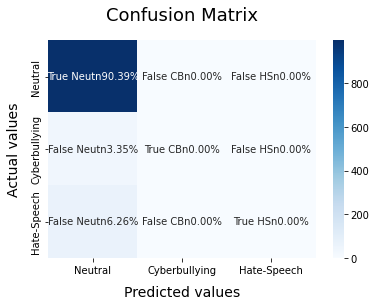

In [10]:
# define and fit the model
LRmodel = OneVsRestClassifier(LogisticRegression(max_iter = 1000))
y_pred1 = LRmodel.fit(X_train, y_train).decision_function(X_test)
model_Evaluate(LRmodel)

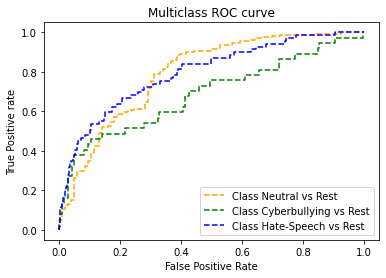

In [11]:
# roc curve for classes -- wywala błąd bo oczekuje 3 kategorii a w y_test są tylko 2
fpr = {}
tpr = {}
thresh ={}

n_class = 3
#y_test2 = y_test + 1

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred1[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class Neutral vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class Cyberbullying vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class Hate-Speech vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

## Model 2 - Linear Support Vector Classification.

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       997
           1       0.44      0.22      0.29        37
           2       0.54      0.20      0.29        69

    accuracy                           0.91      1103
   macro avg       0.64      0.47      0.51      1103
weighted avg       0.89      0.91      0.89      1103



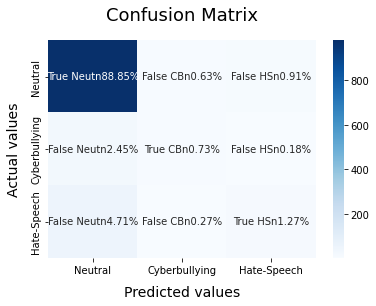

In [12]:
# define and fit the model
#from sklearn.multiclass import OneVsRestClassifier
#from sklearn.svm import SVC

clf = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred2 = clf.fit(X_train, y_train).decision_function(X_test)
model_Evaluate(clf)

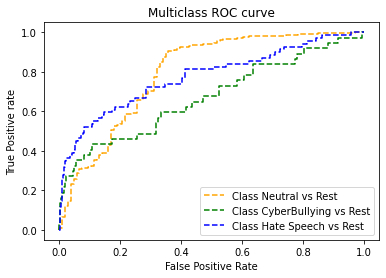

In [13]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred2[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class Neutral vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class CyberBullying vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class Hate Speech vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

## Model 3 - Bidirectional LSTM


### Prepare data for NN model

In [14]:
temp = []
data_to_list = df['lemmatized'].values.tolist()
temp = data_to_list
list(temp[:5])

['faworyt tytuł cracovia zobaczyć typ sprawdzić',
 'brawo daria kibic dobry zły',
 'super polski premiera składać kwiat grób kolaborant doczekać czas',
 'inny droga',
 'odrzut natychmiastowy kwaśny mina problem']

In [15]:
list(temp[:5])

['faworyt tytuł cracovia zobaczyć typ sprawdzić',
 'brawo daria kibic dobry zły',
 'super polski premiera składać kwiat grób kolaborant doczekać czas',
 'inny droga',
 'odrzut natychmiastowy kwaśny mina problem']

In [16]:
data= np.array(temp)

In [17]:
labels = np.array(df['tag_val'])
y = []
for i in range(len(labels)):
    if labels[i] == "Neutral":
        y.append(0)
    if labels[i] == "Cyberbullying":
        y.append(1)
    if labels[i] == "Hate-speech":
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

## Zamiana danych na tensory


In [18]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  111 1464  327]
 [   0    0    0 ...   41    5   56]
 [   0    0    0 ... 1043  857   18]
 ...
 [   0    0    0 ...    8 4327 2379]
 [   0    0    0 ...  147  350   17]
 [   0    0    0 ...    0    0  204]]


In [19]:
print(labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [20]:
# Podział na trening i test
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, random_state=0)
print(len(X_train),len(X_test),len(y_train),len(y_test))

8270 2757 8270 2757


In [27]:
y_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [28]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("/content/drive/MyDrive/POLEVAL_6.2/biLSTM_model.hdf5", 
                              monitor='val_accuracy', 
                              verbose=1,
                              save_best_only=True, 
                              mode='auto', 
                              period=1,
                              save_weights_only=False)
history = model.fit(X_train, 
                     y_train, 
                     epochs=30, 
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint])

Epoch 1/30
259/259 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.9103
Epoch 00001: val_accuracy improved from -inf to 0.91077, saving model to /content/drive/MyDrive/POLEVAL_6.2/biLSTM_model.hdf5
259/259 [==============================] - 68s 86ms/step - loss: 0.3826 - accuracy: 0.9103 - val_loss: 0.3629 - val_accuracy: 0.9108
Epoch 2/30
259/259 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.9108
Epoch 00002: val_accuracy did not improve from 0.91077
259/259 [==============================] - 20s 79ms/step - loss: 0.3455 - accuracy: 0.9108 - val_loss: 0.3386 - val_accuracy: 0.9108
Epoch 3/30
259/259 [==============================] - ETA: 0s - loss: 0.3222 - accuracy: 0.9108
Epoch 00003: val_accuracy did not improve from 0.91077
259/259 [==============================] - 20s 79ms/step - loss: 0.3222 - accuracy: 0.9108 - val_loss: 0.3405 - val_accuracy: 0.9104
Epoch 4/30
259/259 [==============================] - ETA: 0s - loss: 0.3061 

In [29]:
model = keras.models.load_model("/content/drive/MyDrive/POLEVAL_6.2/biLSTM_model.hdf5")

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

87/87 - 3s - loss: 0.3629 - accuracy: 0.9108 - 3s/epoch - 36ms/step
Model accuracy:  0.9107725620269775


In [31]:
predictions = model.predict(X_test)

In [32]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
y_pred =  np.around(predictions, decimals=0).argmax(axis=1)

print(classification_report(y_test.argmax(axis=1), y_pred))


              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2511
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       146

    accuracy                           0.91      2757
   macro avg       0.30      0.33      0.32      2757
weighted avg       0.83      0.91      0.87      2757



### Confusion matrix

In [33]:
# from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

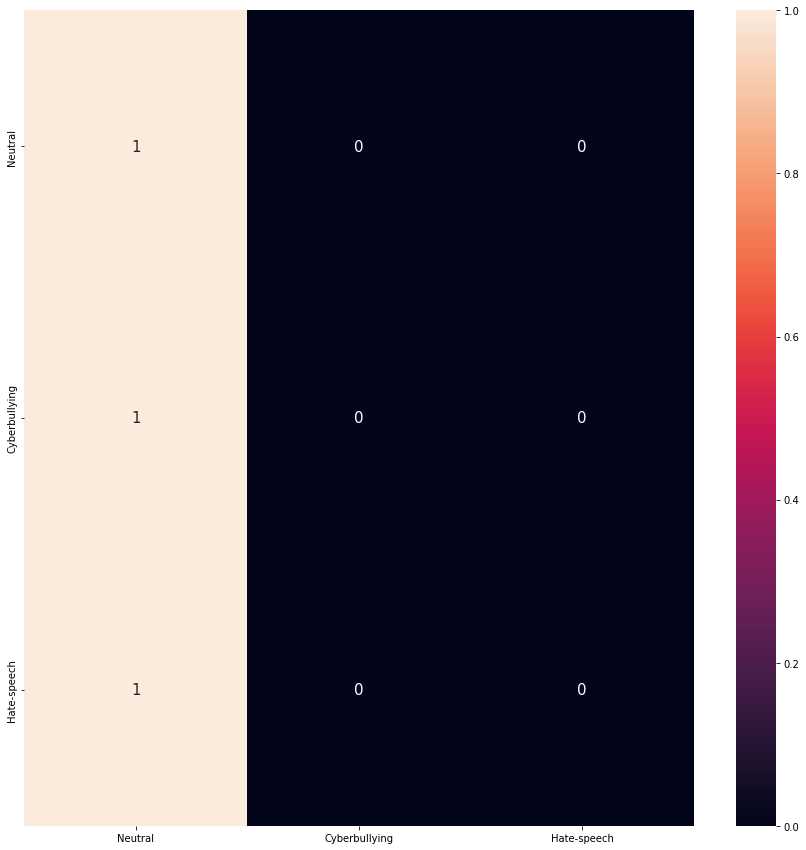

In [34]:
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Cyberbullying', 'Hate-speech'],columns = ['Neutral','Cyberbullying', 'Hate-speech'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})